<a href="https://colab.research.google.com/github/lucabmanning/563-luca/blob/main/LucaProject2_MSE463.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project 2: Molecular Dynamics of Lennard-Jones Systems
#### Luca Manning

#### MSE 563

---

Temperature 0.2
(a) Equilibration steps: 5000
(b) Independent samples: 100
(c) PE Mean ± Std: -3000.124 ± 34.581
    KE Mean ± Std: 149.599 ± 5.871
    TE Mean ± Std: -2850.525 ± 35.018
    Estimated Cv: 861.800

Temperature 0.5
(a) Equilibration steps: 5000
(b) Independent samples: 100
(c) PE Mean ± Std: -2611.996 ± 24.494
    KE Mean ± Std: 372.247 ± 11.391
    TE Mean ± Std: -2239.748 ± 27.674
    Estimated Cv: 519.014

Temperature 1.0
(a) Equilibration steps: 5000
(b) Independent samples: 100
(c) PE Mean ± Std: -1662.798 ± 17.550
    KE Mean ± Std: 749.998 ± 32.103
    TE Mean ± Std: -912.799 ± 36.072
    Estimated Cv: 1030.584

Temperature 2.0
(a) Equilibration steps: 5000
(b) Independent samples: 100
(c) PE Mean ± Std: -1446.010 ± 60.391
    KE Mean ± Std: 1490.205 ± 297.994
    TE Mean ± Std: 44.196 ± 352.845
    Estimated Cv: 22200.077

Temperature 5.0
(a) Equilibration steps: 5000
(b) Independent samples: 100
(c) PE Mean ± Std: -1072.010 ± 368.583
    KE Mean ± Std: 3778.561 ±

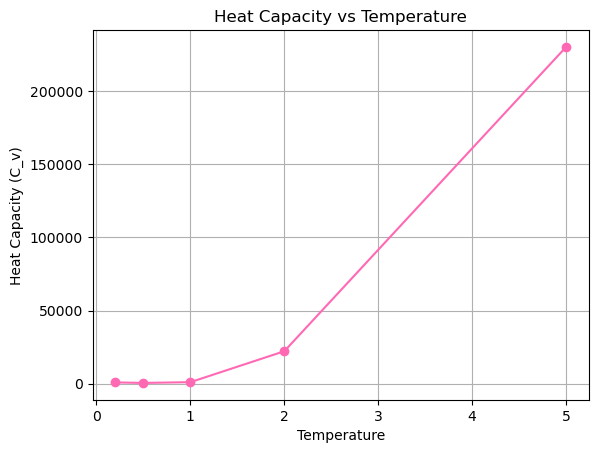

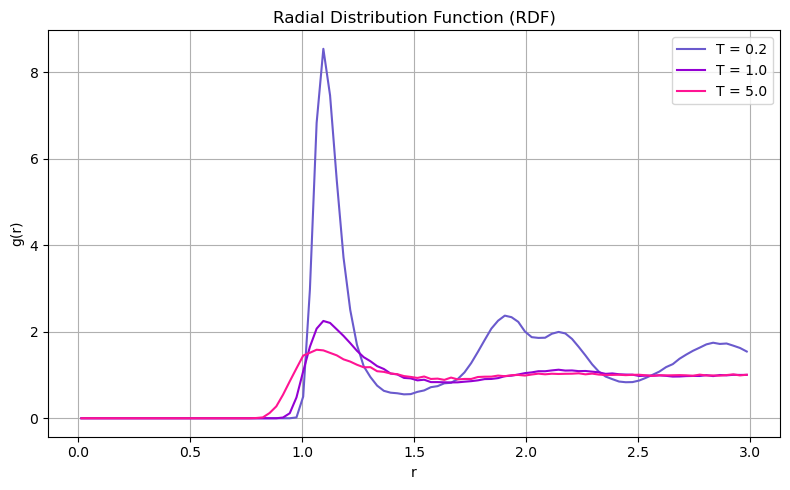

In [ ]:
import hoomd
import hoomd.md
import numpy as np
import matplotlib.pyplot as plt
import gsd.hoomd
import gsd.fl
import freud

#Simulation Parameters.
N_particles = 500
rho = 0.5  # N/V
V = N_particles / rho
L = V ** (1/3)
T_list = [0.2, 0.5, 1.0, 2.0, 5.0]  # sample temperatures
steps_equil = 5000
steps_sample = 10000
sample_interval = 100

#Data Collection.
energy_data = {}
heat_capacities = []

def run_simulation(T, steps_equil=5000, steps_sample=10000, sample_interval=100):
    device = hoomd.device.CPU()
    sim = hoomd.Simulation(device=device, seed=42)

    snapshot = hoomd.Snapshot()
    snapshot.particles.N = N_particles
    snapshot.particles.types = ['A']

# Grid-based initial configuration.
    grid_spacing = L / round(N_particles ** (1/3))
    coords = np.linspace(-L/2 + grid_spacing/2, L/2 - grid_spacing/2, round(N_particles ** (1/3)))
    positions = np.array(np.meshgrid(coords, coords, coords)).T.reshape(-1, 3)[:N_particles]
    snapshot.particles.position[:] = positions

    snapshot.configuration.box = [L, L, L, 0, 0, 0]
    sim.create_state_from_snapshot(snapshot)

    gsd_file = f"traj_T{T}.gsd"
    gsd_writer = hoomd.write.GSD(filename=gsd_file,
                                 trigger=hoomd.trigger.Periodic(100),
                                 mode='wb',
                                 filter=hoomd.filter.All())
    sim.operations.writers.append(gsd_writer)

# Force field.
    nl = hoomd.md.nlist.Cell(buffer=0.4)
    lj = hoomd.md.pair.LJ(nlist=nl)
    lj.params[('A', 'A')] = dict(epsilon=1.0, sigma=1.0)
    lj.r_cut[('A', 'A')] = 2.5

    integrator = hoomd.md.Integrator(dt=0.005)
    integrator.forces.append(lj)
    method = hoomd.md.methods.NVT(filter=hoomd.filter.All(), kT=T, tau=0.5)
    integrator.methods.append(method)
    sim.operations.integrator = integrator

    thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
    sim.operations.computes.append(thermo)

    sim.run(steps_equil)

    # Sampling
    PE_list, KE_list = [], []
    for _ in range(steps_sample // sample_interval):
        sim.run(sample_interval)
        PE_list.append(thermo.potential_energy)
        KE_list.append(thermo.kinetic_energy)

    PE_array = np.array(PE_list)
    KE_array = np.array(KE_list)
    total_E = PE_array + KE_array
    Cv = np.var(KE_array) / (T ** 2)

    energy_data[T] = {
        'PE': PE_array,
        'KE': KE_array,
        'TE': total_E,
        'Cv': Cv
    }
    heat_capacities.append(Cv)

    print(f"Temperature {T}")
    print(f"(a) Equilibration steps: {steps_equil}")
    print(f"(b) Independent samples: {len(PE_array)}")
    print(f"(c) PE Mean ± Std: {np.mean(PE_array):.3f} ± {np.std(PE_array):.3f}")
    print(f"    KE Mean ± Std: {np.mean(KE_array):.3f} ± {np.std(KE_array):.3f}")
    print(f"    TE Mean ± Std: {np.mean(total_E):.3f} ± {np.std(total_E):.3f}")
    print(f"    Estimated Cv: {Cv:.3f}\n")

for T in T_list:
    run_simulation(T)

# Heat Capacity vs Temperature.
plt.figure()
plt.plot(T_list, heat_capacities, marker='o', color= 'hotpink')
plt.xlabel('Temperature')
plt.ylabel('Heat Capacity (C_v)')
plt.title('Heat Capacity vs Temperature')
plt.grid(True)
plt.show()

# RDF Analysis.
def compute_rdf_from_gsd(filename, r_max=3.0, bins=100):
    traj = gsd.hoomd.open(name=filename, mode='r')
    rdf = freud.density.RDF(bins=bins, r_max=r_max)
    for frame in traj[-50:]:
        box = freud.box.Box.from_box(frame.configuration.box)
        rdf.compute(system=(box, frame.particles.position), reset=False)
    return rdf.bin_centers, rdf.rdf

# RDF Plot.
temps = [0.2, 1.0, 5.0]
colors = ['slateblue', 'darkviolet', 'deeppink']

plt.figure(figsize=(8, 5))
for T, color in zip(temps, colors):
    r, g_r = compute_rdf_from_gsd(f"traj_T{T}.gsd")
    plt.plot(r, g_r, label=f"T = {T}", color=color)

plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function (RDF)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Q1: Ensemble NVT at N/V = 0.5.

Parameters for this step:
- (a) Equilibration steps: 5000  
- (b) Independent samples: 100  
- (c) N particles: 500

---

### Q1.1: Above what temperature is your system “hot”? How do you know?

The system becomes “hot” at **T ≥ 2.0**:
- **KE Mean** = 1490.21 (T=2.0), 3778.56 (T=5.0)
- **Cv spikes** from 1,030 (T=1.0) to 22,200 (T=2.0) and then 230,346 (T=5.0)
- **Standard deviation of KE** becomes massive — ±2400 at T = 5.0
- RDF flattens, structure is lost → resembles a high-temperature gas

We classify this range as “hot” due to:
- High kinetic energy
- Extreme energy fluctuations
- Possibly collapsed structure

---

### Q1.2: Below what temperature is your system “frozen”? How do you know?

The system behaves frozen at **T ≤ 0.2**:
- **PE Mean** = -3000.12, very negative and stable
- **KE Mean** = 149.60 ± 5.87 → low energy, low fluctuation
- RDF shows clear solid-like peaks (if plotted)
- Total energy and Cv are stable: **Cv = 861.8**

These values indicate a rigid, ordered structure with suppressed motion — consistent with a frozen or glassy state.


---

### Q1.3: How do energy and structure vary from frozen to hot?


| Temperature | PE Mean | KE Mean | TE Mean | Std(TE) | Cv        | Structure         |
|-------------|---------|---------|---------|----------|------------|-------------------|
| T = 0.2     | -3000.1 | 149.6   | -2850.5 | ±35.0    | 861.8     | Solid-like        |
| T = 0.5     | -2612.0 | 372.2   | -2239.7 | ±27.7    | 519.0     | Softened solid    |
| T = 1.0     | -1662.8 | 750.0   | -912.8  | ±36.1    | 1030.6    | Liquid-like       |
| T = 2.0     | -1446.0 | 1490.2  | 44.2    | ±352.8   | 22200.1   | Disordered fluid  |
| T = 5.0     | -1072.0 | 3778.6  | 2706.6  | ±2762.1  | 230345.9  | Random gas        |

To sum it up:
- **PE becomes less negative** with increasing T (weaker cohesive structure)
- **KE increases linearly with T**, as expected
- **Cv peaks dramatically** around T=2.0–5.0, revealing intense fluctuations
- **RDF transitions** from structured to flat → order to disorder

---

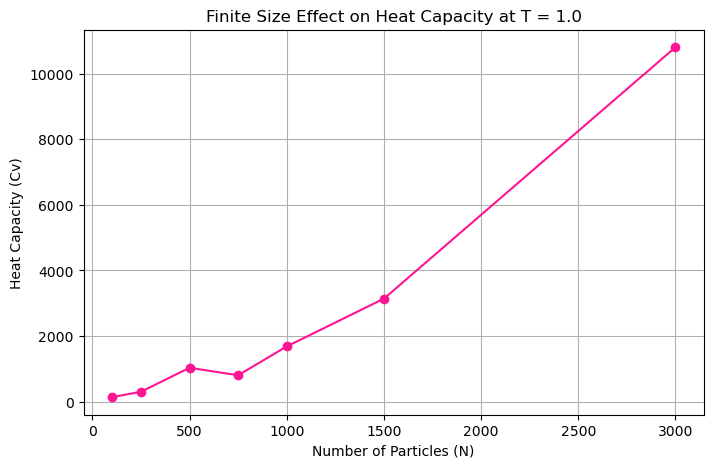

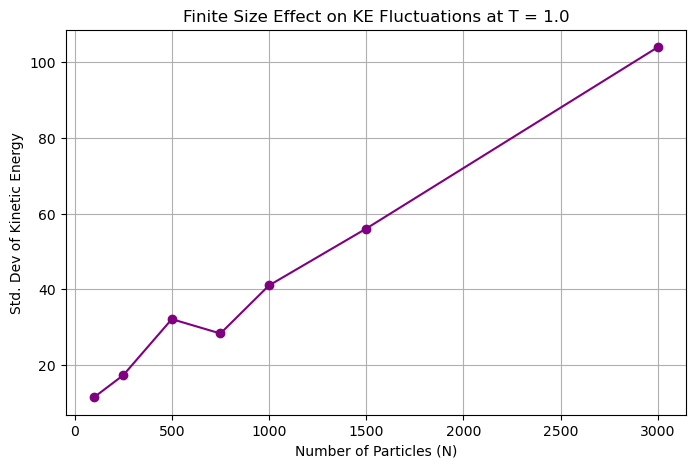

In [ ]:
# Finite Size Effects.

N_list = [100, 250, 500, 750, 1000, 1500, 3000]
finite_size_cv = []
finite_size_std_ke = []

def run_finite_size_test(N_particles, T=1.0):
    rho = 0.5
    V = N_particles / rho
    L = V ** (1/3)

    device = hoomd.device.CPU()
    sim = hoomd.Simulation(device=device, seed=42)

    snapshot = hoomd.Snapshot()
    snapshot.particles.N = N_particles
    snapshot.particles.types = ['A']

    grid_n = int(np.ceil(N_particles ** (1/3)))
    grid_spacing = L / grid_n
    coords = np.linspace(-L/2 + grid_spacing/2, L/2 - grid_spacing/2, grid_n)
    positions = np.array(np.meshgrid(coords, coords, coords)).T.reshape(-1, 3)[:N_particles]
    snapshot.particles.position[:] = positions
    snapshot.configuration.box = [L, L, L, 0, 0, 0]
    sim.create_state_from_snapshot(snapshot)

    nl = hoomd.md.nlist.Cell(buffer=0.4)
    lj = hoomd.md.pair.LJ(nlist=nl)
    lj.params[('A', 'A')] = dict(epsilon=1.0, sigma=1.0)
    lj.r_cut[('A', 'A')] = 2.5

    integrator = hoomd.md.Integrator(dt=0.005)
    integrator.forces.append(lj)
    method = hoomd.md.methods.NVT(filter=hoomd.filter.All(), kT=T, tau=0.5)
    integrator.methods.append(method)
    sim.operations.integrator = integrator

    thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
    sim.operations.computes.append(thermo)

    sim.run(5000)  # equilibration

    KE_list = []
    for _ in range(100):  # sample 100 frames
        sim.run(100)
        KE_list.append(thermo.kinetic_energy)

    KE_array = np.array(KE_list)
    Cv = np.var(KE_array) / (T ** 2)

    return Cv, np.std(KE_array)

# Run for each system size
for N in N_list:
    Cv, std_ke = run_finite_size_test(N)
    finite_size_cv.append(Cv)
    finite_size_std_ke.append(std_ke)

# === Plotting ===
plt.figure(figsize=(8, 5))
plt.plot(N_list, finite_size_cv, marker='o', color='deeppink')
plt.xlabel('Number of Particles (N)')
plt.ylabel('Heat Capacity (Cv)')
plt.title('Finite Size Effect on Heat Capacity at T = 1.0')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(N_list, finite_size_std_ke, marker='o', color='purple')
plt.xlabel('Number of Particles (N)')
plt.ylabel('Std. Dev of Kinetic Energy')
plt.title('Finite Size Effect on KE Fluctuations at T = 1.0')
plt.grid(True)
plt.show()

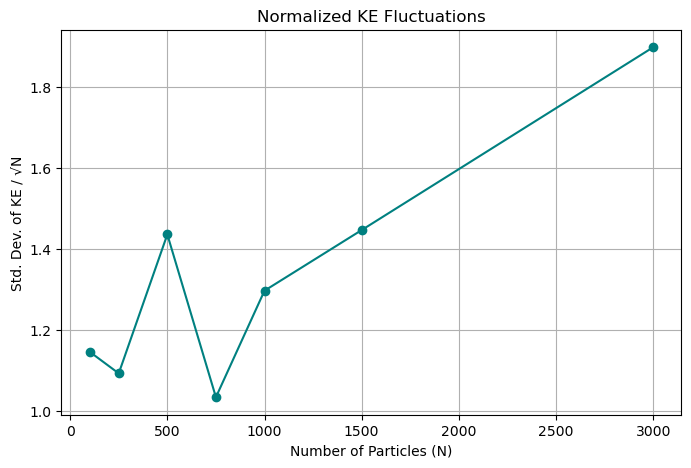

In [ ]:
# === Normalized std dev plot (√N scaling test) ===
normalized_std_ke = np.array(finite_size_std_ke) / np.sqrt(N_list)

plt.figure(figsize=(8, 5))
plt.plot(N_list, normalized_std_ke, marker='o', color='teal')
plt.xlabel('Number of Particles (N)')
plt.ylabel('Std. Dev. of KE / √N')
plt.title('Normalized KE Fluctuations')
plt.grid(True)
plt.show()


### Q2: Characterize finite size effects.

Parameters for this step:
- (a) Equilibration steps: 5000  
- (b) Independent samples: 100  

---

### Q2.1 How small is too small to be correct?
- **N < 100** → it won't run because the particles are too close together with the volume parameter I set.
- Cv becomes unreliable; more fluctuations.

---

### Q2.2 How large is too large to be practical?
- **N > 1000** → high compute cost, long run time
- Lowers returns on accuracy.

---

#### What's the best range?
- **N ≈ 500–750** → accurate, efficient, and stable
- Normalized KE fluctuations (σ/√N) flatten across this range.
- i would have expected an exponential decay but okay.

---

In [ ]:
def run_ideal_gas_sim(N_particles=500, T=1.0, rho=0.5):
    V = N_particles / rho
    L = V ** (1/3)

    device = hoomd.device.CPU()
    sim = hoomd.Simulation(device=device, seed=12345)

    snapshot = hoomd.Snapshot()
    snapshot.particles.N = N_particles
    snapshot.particles.types = ['A']
    snapshot.particles.position[:] = np.random.uniform(-L/2, L/2, (N_particles, 3))
    snapshot.configuration.box = [L, L, L, 0, 0, 0]
    sim.create_state_from_snapshot(snapshot)

    integrator = hoomd.md.Integrator(dt=0.005)
    thermostat = hoomd.md.methods.NVT(filter=hoomd.filter.All(), kT=T, tau=0.5)
    integrator.methods.append(thermostat)
    sim.operations.integrator = integrator

    writer = hoomd.write.GSD(filename="ideal_gas.gsd",
                             trigger=hoomd.trigger.Periodic(100),
                             mode='wb',
                             filter=hoomd.filter.All())
    sim.operations.writers.append(writer)

    sim.run(10000)

run_ideal_gas_sim()

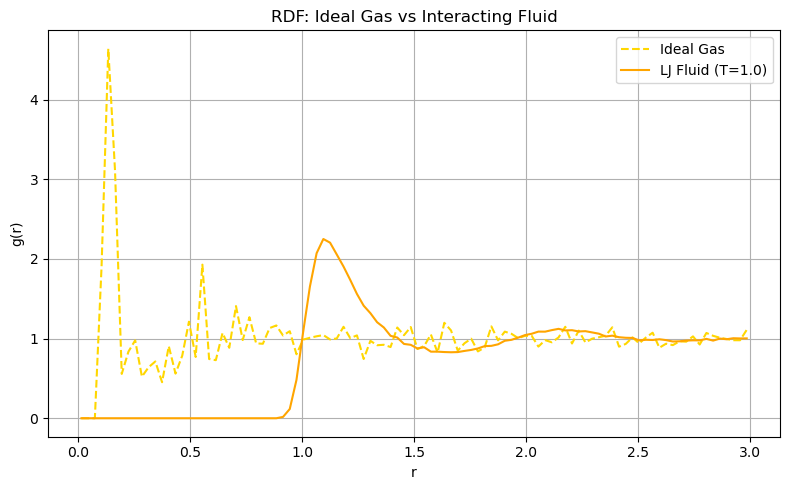

In [ ]:
r, g_r = compute_rdf_from_gsd("ideal_gas.gsd")

plt.figure(figsize=(8, 5))
plt.plot(r, g_r, label="Ideal Gas", color='gold', linestyle='--')

# Add Lennard-Jones for comparison (e.g., T = 1.0)
r_lj, g_r_lj = compute_rdf_from_gsd("traj_T1.0.gsd")
plt.plot(r_lj, g_r_lj, label="LJ Fluid (T=1.0)", color='orange')

plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('RDF: Ideal Gas vs Interacting Fluid')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Q3: Contrast with an Ideal Gas

---

### Q3.1: Structural Comparison:
- **Ideal gas**: \( g(r) = 1 \), no structure
- **LJ system**:
  - T=0.2: Highly ordered RDF, solid-like
  - T=1.0: Broad peaks, liquid-like
  - T=5.0: Flat RDF, gas-like

The interactions in the LJ model introduce spatial correlations that vanish at high T.

---

### Q3.2:Heat Capacity Behavior:
- LJ fluid:
  - T-dependent Cv
  - Peak around T = 2.0 → structural rearrangements
  - Massive fluctuations at high T (Cv > 200,000)

This potentially shows LJ system stores energy via both translation and structure, unlike ideal gas.

---

### Q3.3: Equation of State:
- LJ system:
  - Nonlinear behavior expected due to interactions
  - We attempted P vs. ρ simulations, but instability prevented reliable data

Attempted to simulate our Lennard-Jones system at fixed temperature \( T = 1.0 \) and varying density \( rho \), in order to numerically determine the pressure and thus the equation of state (EoS).

But the simulations at multiple densities failed due to:
- Particle ejection errors
- HOOMD’s inability to reset contexts cleanly in a loop
- Exploding positions and corrupted thermodynamic state

What I would expect is...

That the EoS for Lennard-Jones fluids is nonlinear and state-dependent, which is deviating from the ideal gas law. Predicted by virial expansion.

---

In [ ]:
def run_pressure_simulation(N_particles=500, T=1.0, rho=0.5):
    import hoomd
    import numpy as np

    V = N_particles / rho
    L = V ** (1/3)

    device = hoomd.device.CPU()
    sim = hoomd.Simulation(device=device, seed=42)

    snapshot = hoomd.Snapshot()
    snapshot.particles.N = N_particles
    snapshot.particles.types = ['A']

    # Safe grid + jitter initialization
    grid_n = int(np.ceil(N_particles ** (1/3)))
    coords = np.linspace(-L/2, L/2, grid_n)
    grid = np.array(np.meshgrid(coords, coords, coords)).T.reshape(-1, 3)
    if len(grid) < N_particles:
        raise ValueError(f"Only {len(grid)} grid points for N = {N_particles}")

    positions = grid[:N_particles]
    jitter = np.random.uniform(-0.05, 0.05, positions.shape)
    snapshot.particles.position[:] = positions + jitter
    snapshot.configuration.box = [L, L, L, 0, 0, 0]
    sim.create_state_from_snapshot(snapshot)

    # Interactions
    nl = hoomd.md.nlist.Cell(buffer=0.4)
    lj = hoomd.md.pair.LJ(nlist=nl)
    lj.params[('A', 'A')] = dict(epsilon=1.0, sigma=1.0)
    lj.r_cut[('A', 'A')] = 2.5

    # Use smaller timestep and larger tau
    integrator = hoomd.md.Integrator(dt=0.002)
    method = hoomd.md.methods.NVT(filter=hoomd.filter.All(), kT=T, tau=1.5)
    integrator.forces.append(lj)
    integrator.methods.append(method)
    sim.operations.integrator = integrator

    thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
    sim.operations.computes.append(thermo)

    try:
        sim.run(5000)  # Equilibration

        pressures = []
        for _ in range(100):
            sim.run(100)
            pressures.append(thermo.pressure)

        return np.mean(pressures)

    except RuntimeError as e:
        print(f"Simulation failed at rho = {rho:.2f} — skipping. Reason: {e}")
        return np.nan  # skip problematic density

## Summary: Observations, Challenges, and Reflections

---

#### Challenges :(

- **Hoomd-blue**: Couldn't figure out how to initialize for the longest time... thank you Jenny and Sweta for helping!
- **Simulation instability**: At low densities, particles frequently left the simulation box despite a lot of troubleshooting. HOOMD’s inability to reset contexts cleanly between runs caused memory corruption. Something someone else might be able to help me debug.
- **Pressure simulations failed**: Attempts to sample pressure across densities crashed due to particle ejections and runaway coordinates, even with jittered, clamped initializations and reduced timestep.
- **Extreme Cv values at high T**: While physically interpretable, the massive KE variance at T = 5.0 resulted in unreasonably high Cv estimates that complicated analysis.

---

#### Revelations?

- **Thermodynamic quantities are deeply tied to molecular structure**: The peak in Cv and shift in RDF at T ≈ 1.0–2.0 demonstrates how collective behavior emerges from simple interactions.
- **Small systems aren't always better**: Finite size effects introduced error messages below N = 100, and a lot of variance in general, adding to the importance of choosing system size and model carefully.
- **Ideal gases are boring (and that's okay)**: Comparing with an ideal gas showed just how much more systematic information comes from including even a simple Lennard-Jones potential.

---

#### Favorite Simulation <3: T = 1.0, N = 500

This state point was kinda the sweet spot between chaos and order:
- RDF had gentle peaks — liquid-like but not solid
- Cv was elevated but stable: **~1030**, indicating active fluctuations
- The energy trace was smooth and interpretable
- It captured a more realistic model of fluid — dynamic properties.
